## Planteamiento del problema
Despues de realizar el calculo del QED, se procedio a caracterizar los compuestos con un QED mayor a 0.7, y posteriormente descartar los compuestos con formas moleculares similares, para esto se utilizaron los cluster para realizar esta ultima clasificacion.

El siguiente docuemnto fue suministrado por el grupos de investigacion RamirezLab, y fue acoplado por Nelson Alejandro Amaya Orozco, para ajustarlo de acuerdo a los resultados obtenidos por sus modelos de clasificacion.

In [ ]:
# Importar las librerias necesarias
!pip install rdkit
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from rdkit import Chem, DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import (
    PandasTools,
    Draw,
    rdFingerprintGenerator,
)
from rdkit.Chem import AllChem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 47.3 MB/s eta 0:00:00


## Preparación de datos

Iniciamos cargando el conjunto de datos que contiene los compuestos bioactivos, y se selecinaron las columnas que se necesitaban (CatalogID, SMILES, QED, Probabilidad_Multitarget)

In [ ]:
molecule_dataset = pd.read_csv('mejores_datos.csv', usecols=["CatalogID", "SMILES", "QED","Probabilidad_Multitarget"])
print(f'# total de compuestos: {len(molecule_dataset)}')
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "SMILES")
rdk5_fp_list = [AllChem.RDKFingerprint(mol, maxPath=5, fpSize=1024, nBitsPerHash=2) for mol in molecule_dataset["ROMol"]]
molecule_dataset['rdk5_fp'] = rdk5_fp_list
molecule_dataset.head()

# total de compuestos: 12


,CatalogID,SMILES,QED,Probabilidad_Multitarget,ROMol,rdk5_fp
0,Z2255297702,CN1CCC(CCNC(=O)c2cc3ccncc3s2)CC1,0.944413,0.705377,<rdkit.Chem.rdchem.Mol object at 0x7cfed7d4a730>,"[1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,Z2947117512,COc1cc(=O)[nH]cc1C(=O)N1CCCCCC1c1cccn1C,0.940517,0.700707,<rdkit.Chem.rdchem.Mol object at 0x7cfed7d4a7a0>,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, ..."
2,Z2782581648,Cc1cc(=O)[nH]cc1C(=O)N1CCC(Oc2ccccc2F)CC1,0.940444,0.702550,<rdkit.Chem.rdchem.Mol object at 0x7cfed7d4a810>,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, ..."
3,Z2242906264,Cc1cccc(Cn2cccc(C(=O)N3CCCC(N)C3)c2=O)c1,0.934938,0.720375,<rdkit.Chem.rdchem.Mol object at 0x7cfed7d4a880>,"[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ..."
4,Z1389727601,Cn1cc(C(N)=O)cc1C(=O)N1CCCC1Cc1ccc(F)cc1,0.933286,0.704443,<rdkit.Chem.rdchem.Mol object at 0x7cfed7d4a8f0>,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."


## Matriz de la similitud de Tanimoto
se crea una función cuya entrada es el conjunto de *fingerprints* de los compuestos, y cuya salida es la matriz de similitud de Tanimoto, donde se mide la similitud entre dos compuestos.

In [ ]:
def tanimoto_matrix(fp_list):
    # Crear una matriz identidad
    N = len(fp_list)
    similarity_matrix = np.identity(N)
    # índices de las posiciones de la matriz triangular inferior
    a, b = np.tril_indices(N, 0)
    similarities = list()
    for ind, i in enumerate(fp_list):
        # Compare el fingerprint actual con todos los anteriores en la lista
        similarities = np.append(similarities, DataStructs.BulkTanimotoSimilarity(i, fp_list[:ind+1]))
        # Armar la matriz de distancia
    similarity_matrix[a,b] = similarities
    similarity_matrix[b,a] = similarity_matrix[a,b]
    return similarity_matrix

In [ ]:
list_fingerprints = rdk5_fp_list[0:128]

Ahora, encontramos la matriz de similitud de tanimoto con los diez fingerprints

In [ ]:
similarity_matrix = tanimoto_matrix(list_fingerprints) 
similarity_matrix

array([[1.        , 0.32371134, 0.33413462, 0.35835351, 0.34246575,
        0.34549878, 0.37270341, 0.27079304, 0.36930456, 0.34934498,
        0.34010152, 0.27631579],
       [0.32371134, 1.        , 0.51599147, 0.50314465, 0.57293869,
        0.40674603, 0.44161359, 0.53396226, 0.31702899, 0.44134078,
        0.52678571, 0.43300971],
       [0.33413462, 0.51599147, 1.        , 0.52542373, 0.47309417,
        0.42334096, 0.54973822, 0.46963563, 0.37634409, 0.49347826,
        0.62228261, 0.34782609],
       [0.35835351, 0.50314465, 0.52542373, 1.        , 0.51025057,
        0.41123596, 0.49874687, 0.3682243 , 0.34024896, 0.40567951,
        0.45652174, 0.3326572 ],
       [0.34246575, 0.57293869, 0.47309417, 0.51025057, 1.        ,
        0.48526077, 0.48809524, 0.56494845, 0.34331337, 0.5       ,
        0.62790698, 0.48051948],
       [0.34549878, 0.40674603, 0.42334096, 0.41123596, 0.48526077,
        1.        , 0.53645833, 0.41960784, 0.37796976, 0.61556604,
        0.4800995 ,

Podemos representarla por medio de un mapa de calor:

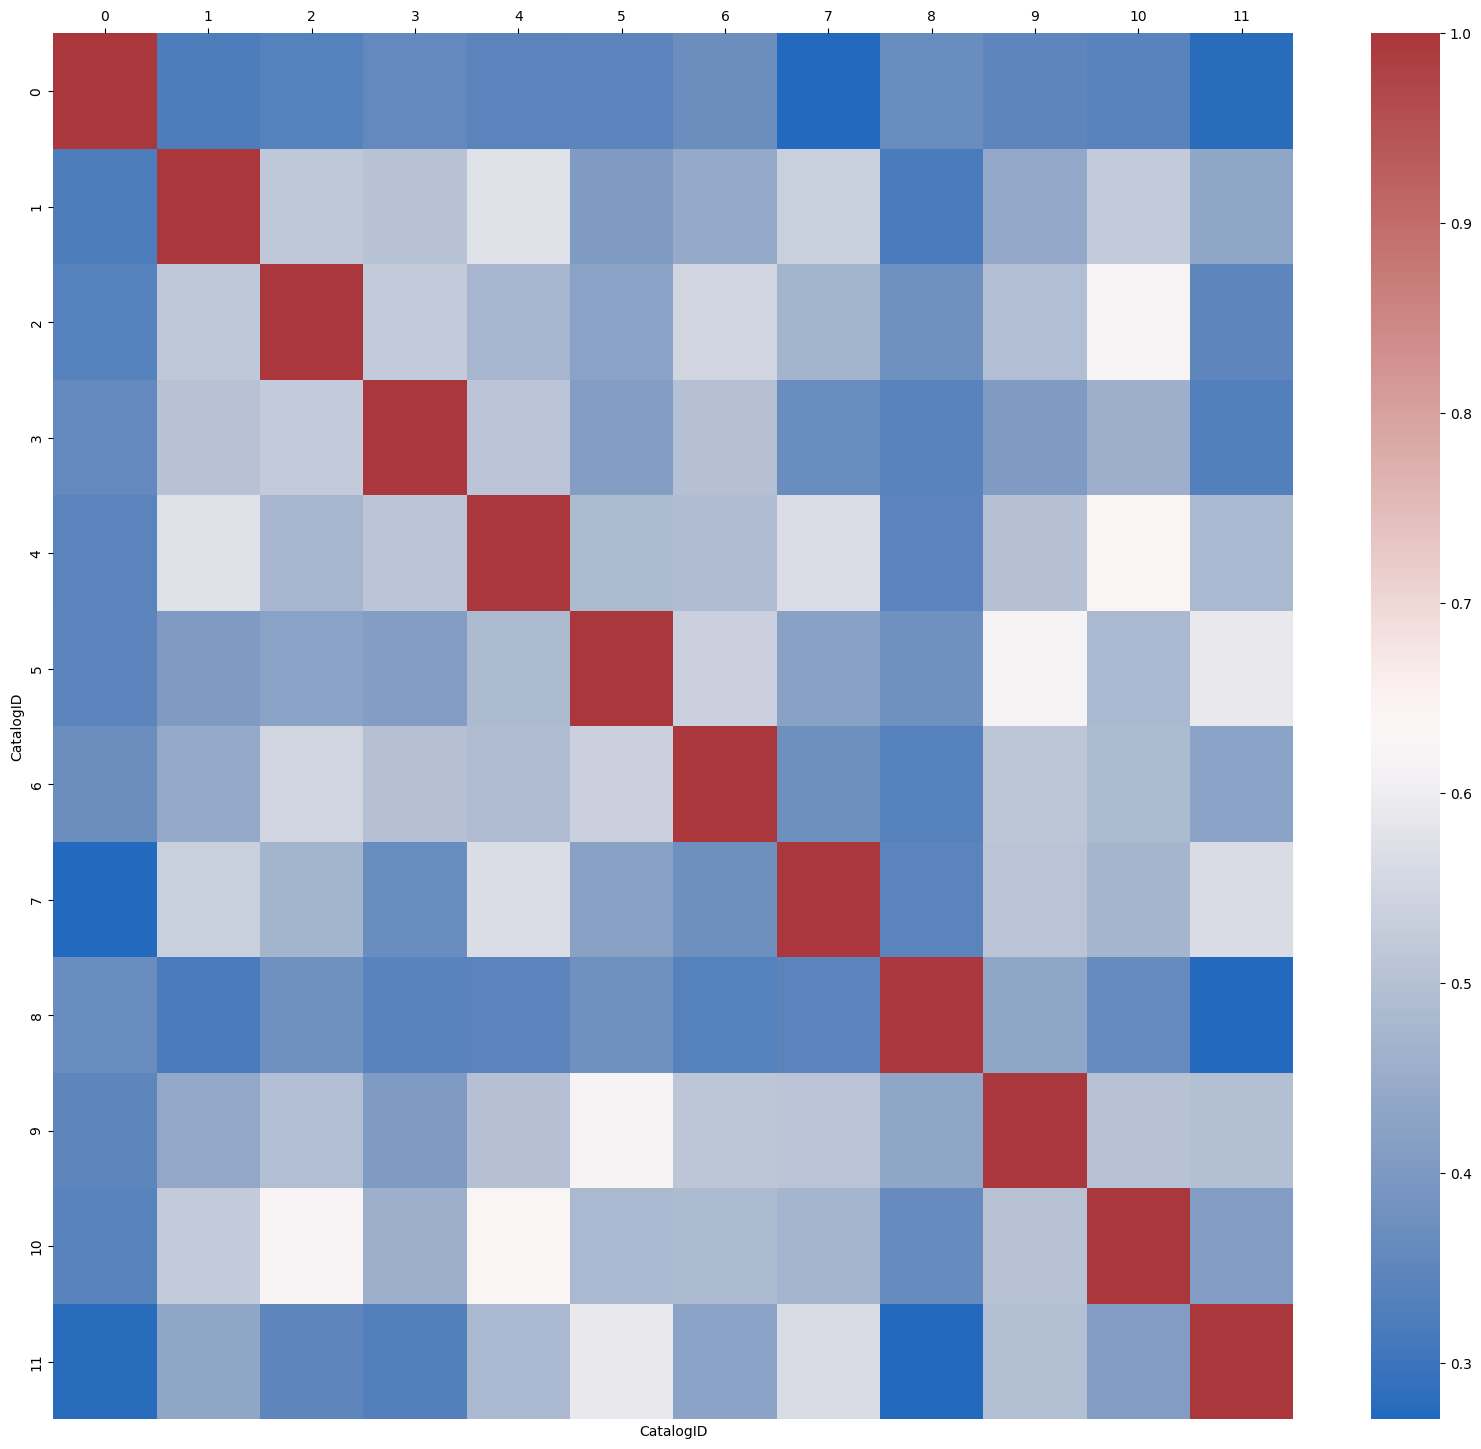

In [ ]:
similarity_matrix = tanimoto_matrix(list_fingerprints) 
plt.figure(figsize=(20, 18))
ax = sns.heatmap(similarity_matrix, cmap="vlag") 
ax.set(xlabel="CatalogID", ylabel="CatalogID")
ax.xaxis.tick_top()
output_image_file = "similarity_heatmap.png"
plt.savefig(output_image_file)
plt.show()

#### Agrupamiento por distancias
Como lo explicamos inicialmente, el **agrupamiento por aglomeración** consiste en fusionar consecutivamente aquellos clústers que estén más cercados, para entender el agrupamiento podemos utilizar el método [`linkage`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage), el cual crea una *matriz de enlace* (linkage matrix) con el orden con el cual se agruparon los diferentes clústers (por defecto, la metrica de medida es la *distancia euclideana* y el método de agrupamiento es el *punto más cercano*), nosotros vamos a trabajar con la distancia media de los elementos del agrupamiento (*average*).

In [ ]:
Z = linkage(similarity_matrix, method='average')
Z

array([[ 4.        , 10.        ,  0.56433765,  2.        ],
       [ 5.        ,  9.        ,  0.56833808,  2.        ],
       [ 1.        , 12.        ,  0.66069867,  3.        ],
       [ 7.        , 11.        ,  0.67693048,  2.        ],
       [ 2.        ,  6.        ,  0.6797329 ,  2.        ],
       [ 3.        , 16.        ,  0.72332092,  3.        ],
       [14.        , 17.        ,  0.74890779,  6.        ],
       [13.        , 15.        ,  0.75792083,  4.        ],
       [18.        , 19.        ,  0.8414848 , 10.        ],
       [ 0.        ,  8.        ,  0.90194762,  2.        ],
       [20.        , 21.        ,  1.05282566, 12.        ]])

#### Representación: el *dendograma*
La manera de representar un agrupamiento jerárquico es con un dendrograma

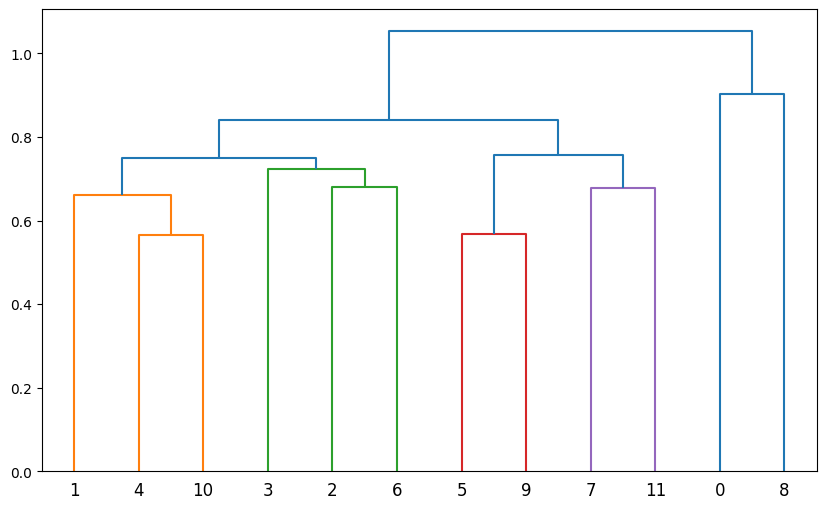

In [ ]:
dn = dendrogram(Z)
n = len(dn['ivl'])  # Obtiene la cantidad de datos en el eje x
fig_width = max(10, n * 0.2)  # Establece un ancho mínimo de la figura
fig_height = max(6, n * 0.1)  # Establece una altura mínima de la figura

fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)

# Muestra la gráfica
plt.show()

#### Clustermap
Todo lo anterior se puede organizar en una matriz y graficar por medio de un mapa de calor de agrupamiento jerárquico, note que el orden de los compuestos no necesariamente es el mismo orden que el del dendograma

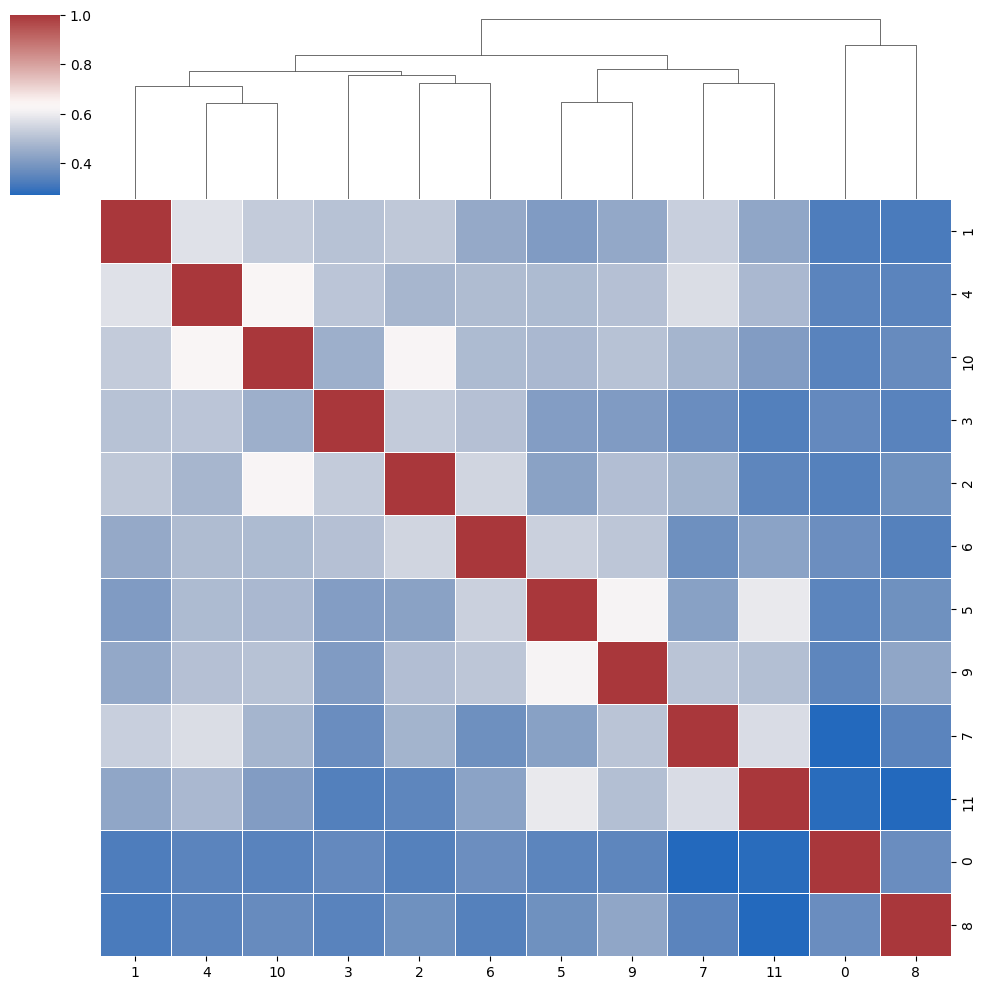

In [ ]:
g = sns.clustermap(similarity_matrix, method='average',
                   cmap="vlag", dendrogram_ratio=(.1,.2),
                   linewidths=.5)
g.ax_row_dendrogram.remove()

In [ ]:
Z = linkage(similarity_matrix)
fcluster(Z, t=0.6, criterion='distance')

array([8, 4, 3, 7, 3, 1, 6, 5, 9, 1, 3, 2], dtype=int32)

### Algoritmo de agrupamiento *Butina*: Centroides y esferas de exclusión
Un algoritmo utilizado comunmente para agrupar moléculas es el conocido como el *algortimo de agrupamiento Butina* (Butina clustering algorithm)<sup> **5** </sup>

Podemos utilizar la librería `rdkit` para implementar este algorítmo (`Butina.ClusterData`). Como entrada se necesita una lista con las distancias de Tanimoto de los compuestos. Esta lista la podemos encontrar a partir de la matriz de similitud de Tanimoto donde las distancias se pueden hallar con la fórmula $distancia = 1 - similitud$.

Para armar la lista podemos utilizar la función de la matriz de tanimoto, separar solamente los elementos que están debajo de la diagonal principal y hallar la distancia

In [ ]:
similarity_matrix = tanimoto_matrix(list_fingerprints)  # Matriz de similitud
a, b = np.tril_indices(len(list_fingerprints), -1)  # índices de los elementos debajo de la diagonal principal
dist_similarity_matrix = 1 - similarity_matrix[a, b]  # distancias de los compuestos

In [ ]:
clusters = Butina.ClusterData(dist_similarity_matrix,len(list_fingerprints), distThresh=0.6, isDistData=True)
clusters = sorted(clusters, key=len, reverse=True)
clusters


[(9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11), (0,)]

## Método del codo (Elbow Method)
Uno de los problemas que nos encontramos a la hora de aplicar el agrupamiento es la elección del número de Clusters. No existe un criterio objetivo ni ampliamente válido para la elección de un número óptimo de Clusters; pero tenemos que tener en cuenta, que una mala elección de los mismos puede dar lugar a realizar agrupaciones de datos muy heterogéneos (pocos Clusters); o datos, que siendo muy similares unos a otros los agrupemos en Clusters diferentes (muchos Clusters).

El método del codo utiliza los valores de la inercia obtenidos tras aplicar el agrupamiento para diferentes números de clusters (desde 1 a N Clusters), siendo la **inercia** la *suma de las distancias al cuadrado de cada objeto del Cluster a su centroide*. Luego, podemos hallar el *promedio* de las inercias para cada N (comúnmente llamado *distorsión*) y representamos en una gráfica la distorsión respecto al número de clústers<sup> **6** </sup>. La gráfica nos dirve para apreciar el cambio y a partir de esta podemos estimar el número óptimo de clústers a seleccionar.

Comenzamos definiendo una función que determine la inercia y distorsión, ya que vamos a utilizar el método de Butina para hacer el clústering, debemos tener en cuenta que este depende del *umbral de similitud* y a partir de este umbral se halla el número de clústers (entre más pequeño sea el umbral, más clústers, pues es menor la cantidad de moléculas similares).

In [ ]:
def distorion_tanimoto(clusters, full_dataset):
    inertia = list()
    for cluster in clusters:
        cluster_dataset = full_dataset.iloc[list(cluster)]
        # centroide
        rdk5_fp_query = cluster_dataset['rdk5_fp'].iloc[0]  # Utiliza las huellas RDK5
        # lista de elementos del clúster
        rdk5_fp_list = list(cluster_dataset['rdk5_fp'])  # Utiliza las huellas RDK5
        # cuadrado de la distancia intra-cluster
        sqrt_dist_to_centroid = (1 - np.array(DataStructs.BulkTanimotoSimilarity(rdk5_fp_query, rdk5_fp_list)))**2
        # suma del cuadrado de la distancia de cada elemento al centro del clúster
        inertia.append(sum(sqrt_dist_to_centroid))
    # media de las inercias de cada clúster
    distortion = np.mean(inertia)
    return len(clusters), distortion

In [ ]:
result = list()
molecule_mini_dataset = molecule_dataset[:10]
list_fingerprints = molecule_mini_dataset['rdk5_fp']  # Utiliza las huellas RDKIT
similarity_matrix = tanimoto_matrix(list_fingerprints)  # Matriz de similitud
a, b = np.tril_indices(len(list_fingerprints), -1)  # índices de los elementos debajo de la diagonal principal
dist_similarity_matrix = 1 - similarity_matrix[a, b]  # distancias de los compuestos
for i in np.arange(0, 1, 0.05):
    cutoff = round(i, 2)
    clusters = Butina.ClusterData(dist_similarity_matrix, len(list_fingerprints), distThresh=cutoff, isDistData=True)
    n, dist = distorion_tanimoto(clusters, molecule_mini_dataset)
    result.append((cutoff, n, dist))
table = pd.DataFrame(result, columns=['cutoff', 'N_clusters', 'distortion'])
table

,cutoff,N_clusters,distortion
0,0.00,10,0.000000
1,0.05,10,0.000000
2,0.10,10,0.000000
3,0.15,10,0.000000
4,0.20,10,0.000000
5,0.25,10,0.000000
6,0.30,10,0.000000
7,0.35,10,0.000000
8,0.40,9,0.016421
9,0.45,7,0.074206


<Axes: xlabel='N_clusters'>

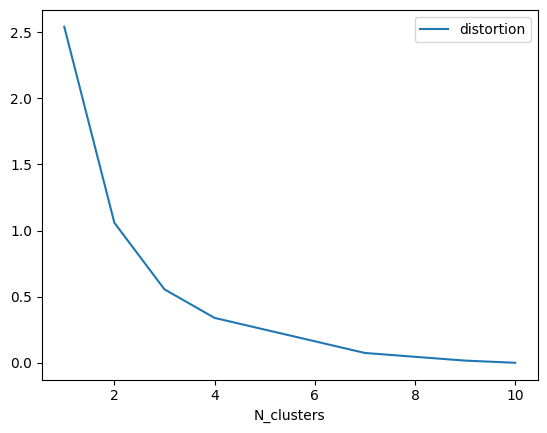

In [ ]:
table.plot(x='N_clusters', y='distortion')

In [ ]:
similarity_matrix_full = tanimoto_matrix(rdk5_fp_list)
similarity_matrix_full.shape

(12, 12)

Observemos el mapa de calor de la matriz de similitud, la cual aún no está organizada

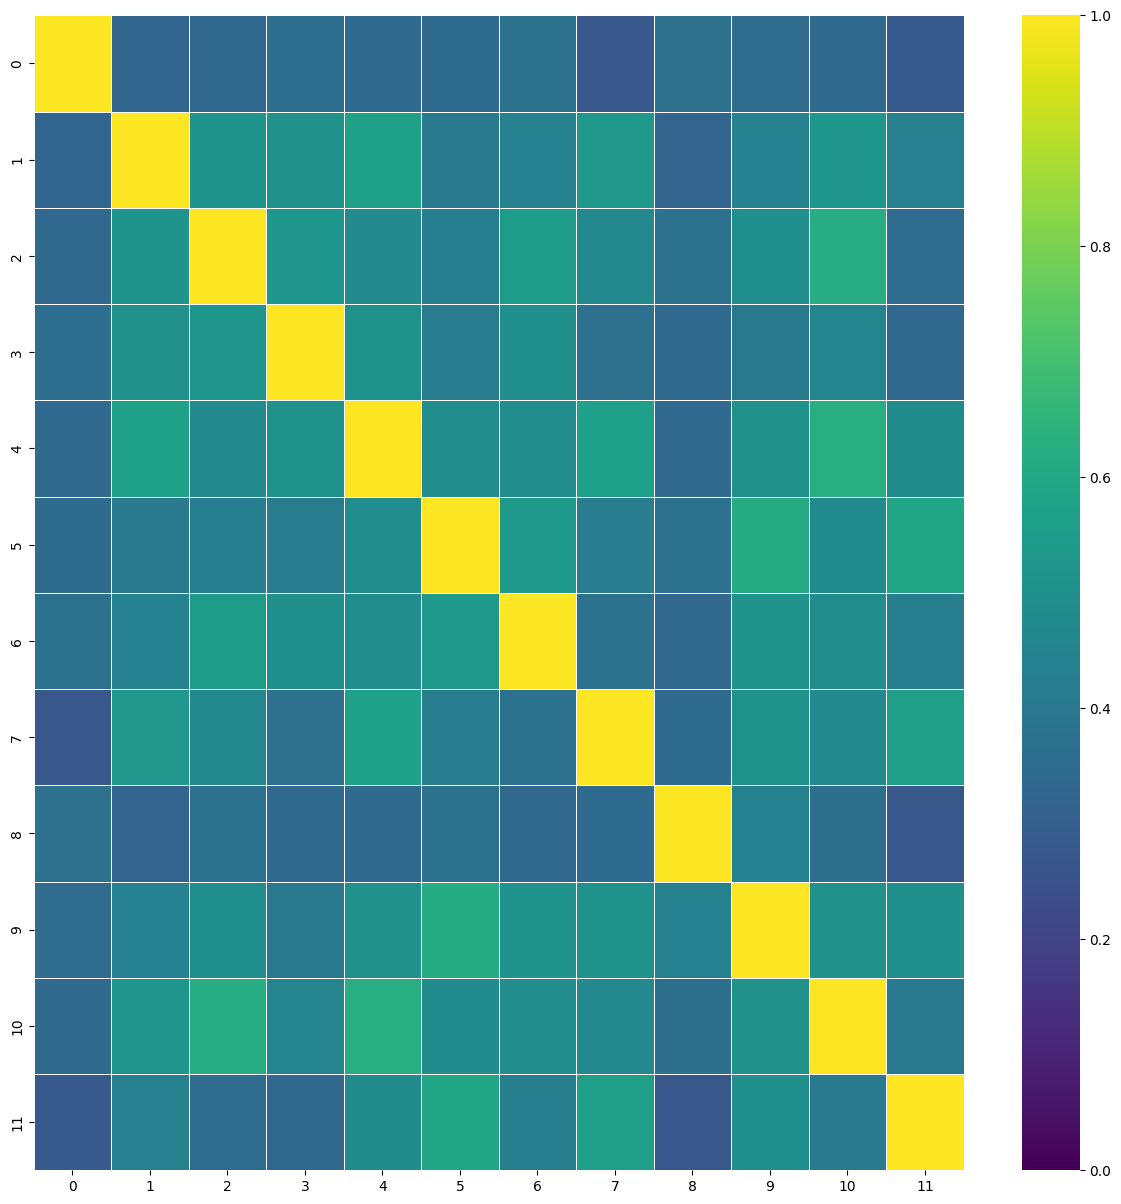

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(similarity_matrix_full, cmap="viridis", annot=False, linewidths=.5, vmin=0, vmax=1)

In [ ]:
def cluster_fingerprints(fp_list, cutoff=0.5):
    # Calcular la matriz similitud de Tanimoto
    similarity_matrix = tanimoto_matrix(fp_list)  # Matriz de similitud
    # Encontrar la distancias entre los compuestos, guardar los datos como una lista
    a, b = np.tril_indices(len(fp_list), -1)
    dist_similarity_matrix = 1 - similarity_matrix[a, b]
    # Ahora agrupar los datos con el algoritmo Butina:
    clusters = Butina.ClusterData(dist_similarity_matrix, len(fp_list), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [ ]:
# Ejecutar el procedimiento de agrupación para el conjunto de datos, distancia: 0.2
clusters = cluster_fingerprints(rdk5_fp_list, cutoff=0.5)
# Clústers más grandes
print(clusters[:129])

[(92, 25, 27, 29, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 52, 53, 57, 58, 59, 61, 62, 66, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 94, 95, 96, 99, 104, 105, 106, 107, 108, 109, 113, 115, 116, 121), (19, 20, 21, 22, 23, 24, 26, 31, 32, 46, 50, 51, 54, 55, 56, 64, 65, 67, 71, 79, 86, 93, 97, 101, 102, 112, 114, 120, 122, 123, 124, 125, 126, 127), (17, 0, 2, 3, 5, 6, 7, 8, 10, 15, 16, 18), (118, 9, 117, 119), (98, 28, 30, 33), (63, 103, 111), (11, 1, 4), (110, 100), (60,), (12,), (14,), (13,)]


In [ ]:
agrup = list(map(len, clusters))
unique, counts = np.unique(agrup, return_counts=True)
frec_table = np.flip(np.array([unique, counts]).T) # reversed order
frec_table

array([[ 1, 62],
       [ 1, 34],
       [ 1, 12],
       [ 2,  4],
       [ 2,  3],
       [ 1,  2],
       [ 4,  1]])

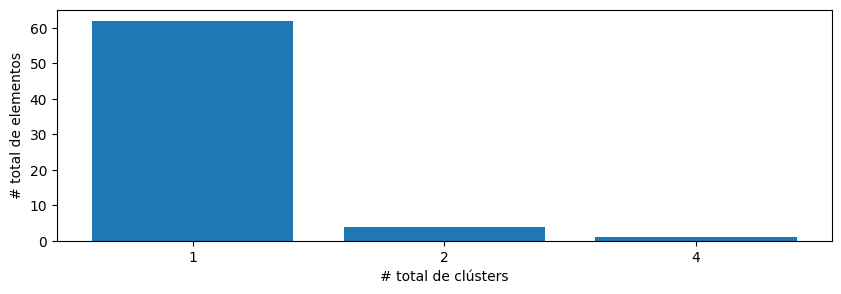

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))  # Configurar la figura de matplotlib
ax.bar(list(map(str, frec_table[:, 0])), frec_table[:, 1])
ax.set_xlabel("# total de clústers")
ax.set_ylabel("# total de elementos")
plt.show()
plt.close()

In [ ]:
list_ind_cluster0 = list(clusters[0])
molecules_cluster0 = molecule_dataset.iloc[list_ind_cluster0]
molecules_cluster0

,CatalogID,SMILES,QED,Probabilidad_Multitarget,ROMol,rdk5_fp
92,Z1818334602,CN1C(=O)c2ccc(C(=O)N3CCC[C@@H](N)C3)cc2C1=O.Cl,0.778188,0.717693,<rdkit.Chem.rdchem.Mol object at 0x7ec58f012c70>,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
25,Z28111400,Cc1ccccc1C(C)NC(=O)c1ccc2c(c1)C(=O)N(C)C2=O,0.883657,0.700585,<rdkit.Chem.rdchem.Mol object at 0x7ec58f010f20>,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
27,Z1456282934,CN(C(=O)c1cccc(CN2C(=O)c3ccccc3C2=O)c1)C1CCNCC...,0.782296,0.722239,<rdkit.Chem.rdchem.Mol object at 0x7ec58f011000>,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
29,Z2392955093,CN1C(=O)c2ccc(C(=O)NCC3CCCNC3)cc2C1=O,0.803262,0.724102,<rdkit.Chem.rdchem.Mol object at 0x7ec58f0110e0>,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
34,Z932133050,Cc1ccc2c(c1)C(=O)N(CCC(=O)N(C)CC1CCCC1)C2=O,0.780847,0.716588,<rdkit.Chem.rdchem.Mol object at 0x7ec58f011310>,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
...,...,...,...,...,...,...
109,Z295260132,CCOc1ccc(CN2C(=O)c3ccccc3C2=O)cc1C(=O)N1CCN(C(...,0.601536,0.726054,<rdkit.Chem.rdchem.Mol object at 0x7ec58f0133e0>,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
113,Z871951350,CCOc1ccccc1NC(=O)c1ccc2c(c1)C(=O)N(C1CC1)C2=O,0.840969,0.708314,<rdkit.Chem.rdchem.Mol object at 0x7ec58f0135a0>,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
115,Z53838034,CC(C)CN1C(=O)c2ccc([N+](=O)[O-])cc2C1=O,0.464100,0.740324,<rdkit.Chem.rdchem.Mol object at 0x7ec58f013680>,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
116,Z166799148,O=C(CCCN1C(=O)c2ccc(Br)cc2C1=O)N1CCCCC1,0.756400,0.709979,<rdkit.Chem.rdchem.Mol object at 0x7ec58f0136f0>,"[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."


62 moleculas del clúster de mayor tamaño


/usr/local/lib/python3.10/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


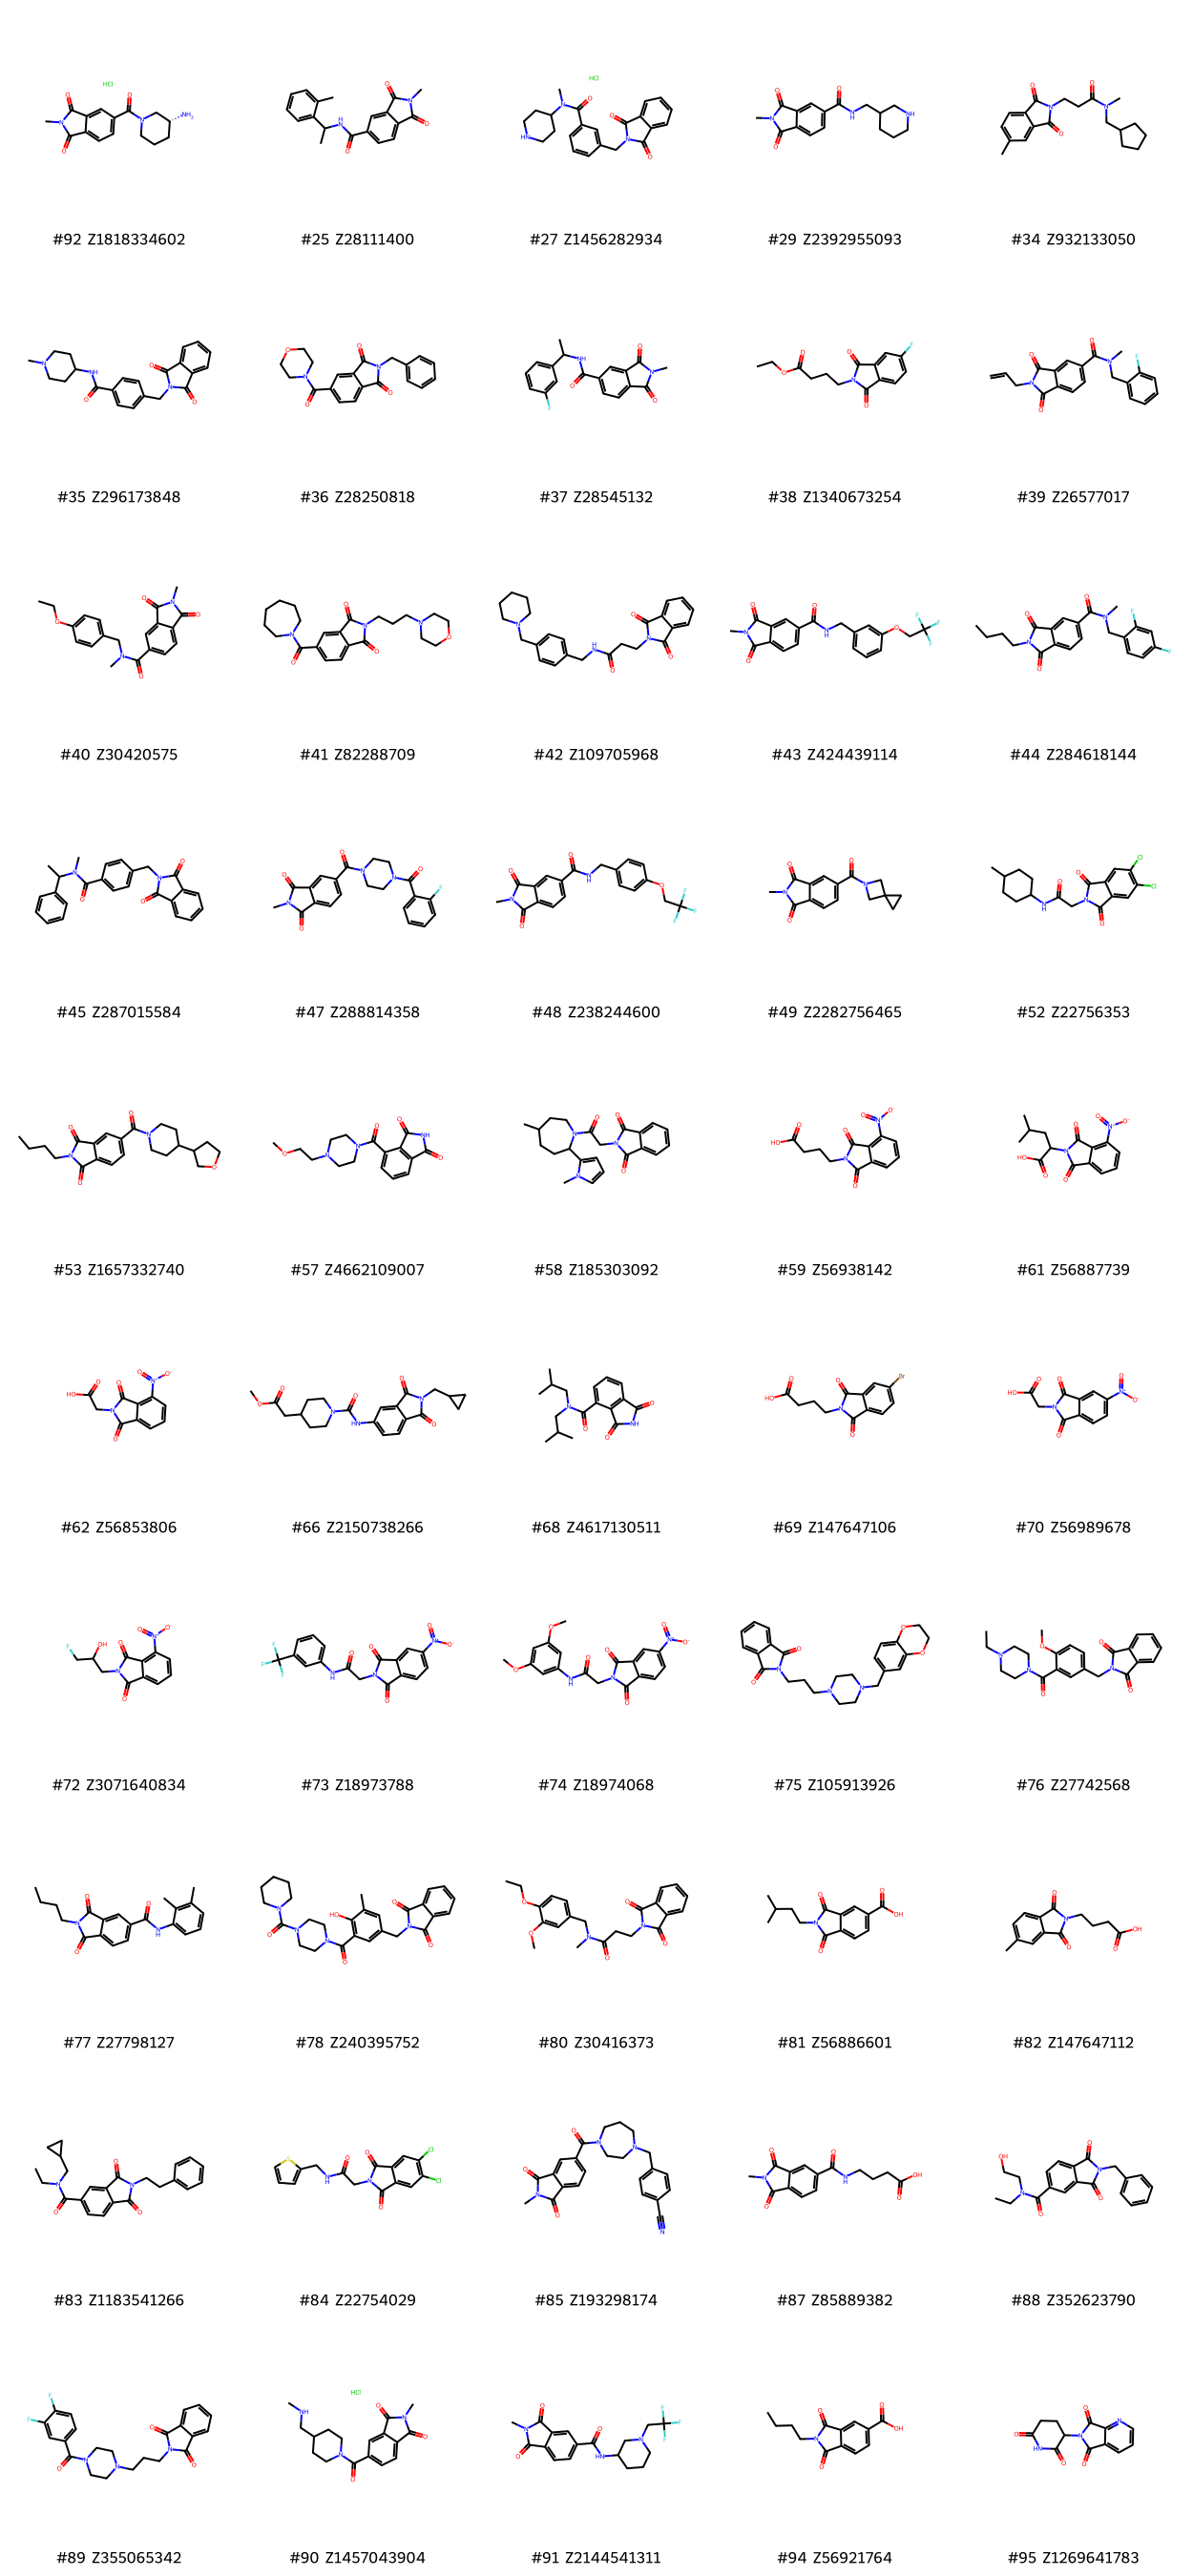

In [ ]:
print(f'{len(molecules_cluster0)} moleculas del clúster de mayor tamaño')
legends = [
    f"#{index} {molecule['CatalogID']}"
    for index, molecule in molecules_cluster0.iterrows()
]

Chem.Draw.MolsToGridImage(
    mols= molecules_cluster0["ROMol"].tolist(),
    legends=legends,
    molsPerRow=5,
    subImgSize=(250, 270),
)

In [ ]:
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g10 = sum(1 for c in clusters if len(c) > 10)

print("Número total de clústeres: ", len(clusters))
print("# clusters con solo 1 compuesto: ", num_clust_g1)
print("# clusters con >5 compuestos: ", num_clust_g5)
print("# clusters con >10 compuestos: ", num_clust_g10)

Número total de clústeres:  12
# clusters con solo 1 compuesto:  4
# clusters con >5 compuestos:  3
# clusters con >10 compuestos:  3


In [ ]:
result = list()
# Ahora utilizamos el total de moléculas
list_fingerprints = molecule_dataset['rdk5_fp']
similarity_matrix = tanimoto_matrix(list_fingerprints)  # Matriz de similitud
a, b = np.tril_indices(len(list_fingerprints), -1)  # índices de los elementos debajo de la diagonal principal
dist_similarity_matrix = 1 - similarity_matrix[a, b] # distancias de los compuestos
for i in np.arange(0,1,0.05):
    cutoff = round(i,2)
    clusters = Butina.ClusterData(dist_similarity_matrix,len(list_fingerprints), distThresh=cutoff, isDistData=True)
    n, dist = distorion_tanimoto(clusters, molecule_dataset)
    result.append((cutoff, n, dist))
table = pd.DataFrame(result, columns=['cutoff', 'N_clusters', 'distortion'])
table

,cutoff,N_clusters,distortion
0,0.00,127,0.000000
1,0.05,122,0.000052
2,0.10,109,0.000960
3,0.15,84,0.006545
4,0.20,64,0.022021
5,0.25,51,0.046427
6,0.30,42,0.099671
7,0.35,35,0.197393
8,0.40,24,0.385364
9,0.45,14,0.901052


<Axes: xlabel='N_clusters'>

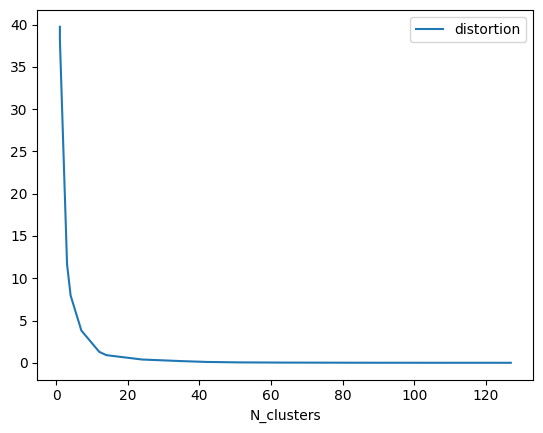

In [ ]:
table.plot(x='N_clusters', y='distortion')

In [ ]:
result = list()
# Ahora utilizamos el total de moléculas
list_fingerprints = molecule_dataset['rdk5_fp']
similarity_matrix = tanimoto_matrix(list_fingerprints)  # Matriz de similitud
a, b = np.tril_indices(len(list_fingerprints), -1)  # índices de los elementos debajo de la diagonal principal
dist_similarity_matrix = 1 - similarity_matrix[a, b] # distancias de los compuestos
for i in np.arange(0,0.5,0.05):
    cutoff = round(i,2)
    clusters = Butina.ClusterData(dist_similarity_matrix,len(list_fingerprints), distThresh=cutoff, isDistData=True)
    n, dist = distorion_tanimoto(clusters, molecule_dataset)
    result.append((cutoff, n, dist))
table = pd.DataFrame(result, columns=['cutoff', 'Clusters', 'Distorsion'])
table

,cutoff,Clusters,Distorsion
0,0.00,127,0.000000
1,0.05,122,0.000052
2,0.10,109,0.000960
3,0.15,84,0.006545
4,0.20,64,0.022021
5,0.25,51,0.046427
6,0.30,42,0.099671
7,0.35,35,0.197393
8,0.40,24,0.385364
9,0.45,14,0.901052


<Axes: xlabel='Clusters'>

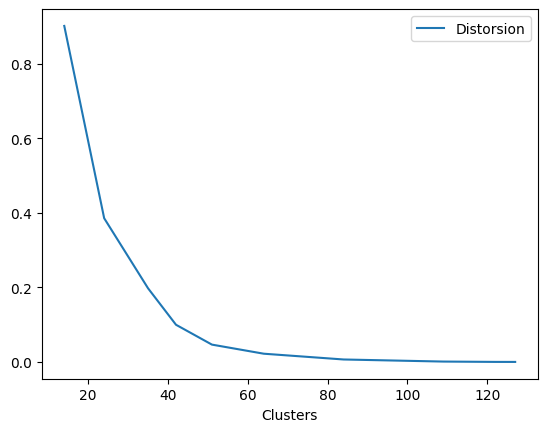

In [ ]:
table.plot(x='Clusters', y='Distorsion')

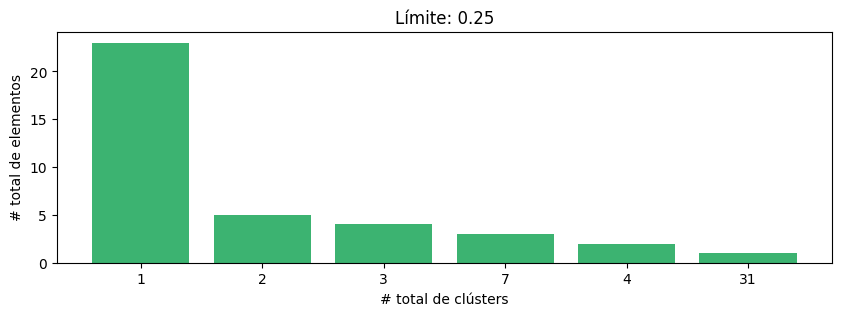

In [ ]:
clusters = cluster_fingerprints(rdk5_fp_list, cutoff=0.25)
fig, ax = plt.subplots(figsize=(10, 3)) # Configurar la figura de matplotlib
agrup = list(map(len, clusters))
unique, counts = np.unique(agrup, return_counts=True)
frec_table = np.flip(np.array([unique, counts]).T) # reversed order

ax.bar(list(map(str, frec_table[:, 0])), frec_table[:, 1], color="mediumseagreen")
ax.set_title(f"Límite: 0.25")
ax.set_xlabel("# total de clústers")
ax.set_ylabel("# total de elementos")
plt.show()
plt.close()

In [ ]:
list_ind_cluster0 = list(clusters[1])
molecules_cluster0 = molecule_dataset.iloc[list_ind_cluster0]
molecules_cluster0

,CatalogID,SMILES,QED,Probabilidad_Multitarget,ROMol,rdk5_fp,Cluster
46,Z511253040,Cc1cccc(C(=O)N2CCC(Oc3ccc(C)c(C)c3)CC2)n1,0.864544,0.724303,<rdkit.Chem.rdchem.Mol object at 0x7ec58f011850>,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",2
24,Z1588815064,CCc1ccnc(C(=O)N2CCC(Oc3cccc(C#N)c3)CC2)c1,0.860415,0.714749,<rdkit.Chem.rdchem.Mol object at 0x7ec58f010eb0>,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",2
50,Z1343836757,NC(=O)c1c[nH]c(C(=O)N2CCC(Oc3ccccc3)CC2)c1,0.901762,0.704435,<rdkit.Chem.rdchem.Mol object at 0x7ec58f011a10>,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",25
71,Z809436022,CCOc1ccccc1OC1CCN(C(=O)c2ccccn2)CC1,0.846741,0.703919,<rdkit.Chem.rdchem.Mol object at 0x7ec58f012340>,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",2
79,Z809752942,O=C(c1ccc2ccccc2n1)N1CCC(Oc2ccccc2)CC1,0.729953,0.719966,<rdkit.Chem.rdchem.Mol object at 0x7ec58f0126c0>,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",2
93,Z800002944,O=C(c1cc2ccccc2[nH]1)N1CCC(Oc2ccccc2)CC1,0.796463,0.724209,<rdkit.Chem.rdchem.Mol object at 0x7ec58f012ce0>,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",2
97,Z1343785724,Cc1ccc(OC2CCN(C(=O)c3cc(C(N)=O)c[nH]3)CC2)cc1C,0.894902,0.730755,<rdkit.Chem.rdchem.Mol object at 0x7ec58f012ea0>,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",2
102,Z511250440,Cc1cnc(C(=O)N2CCC(Oc3ccc(C)c(C)c3)CC2)cn1,0.870033,0.701060,<rdkit.Chem.rdchem.Mol object at 0x7ec58f0130d0>,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",38
112,Z812454146,O=C(c1cc2ccccc2c(=O)[nH]1)N1CCC(Oc2ccccc2)CC1,0.790481,0.720328,<rdkit.Chem.rdchem.Mol object at 0x7ec58f013530>,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",21


9 moleculas del clúster de mayor tamaño


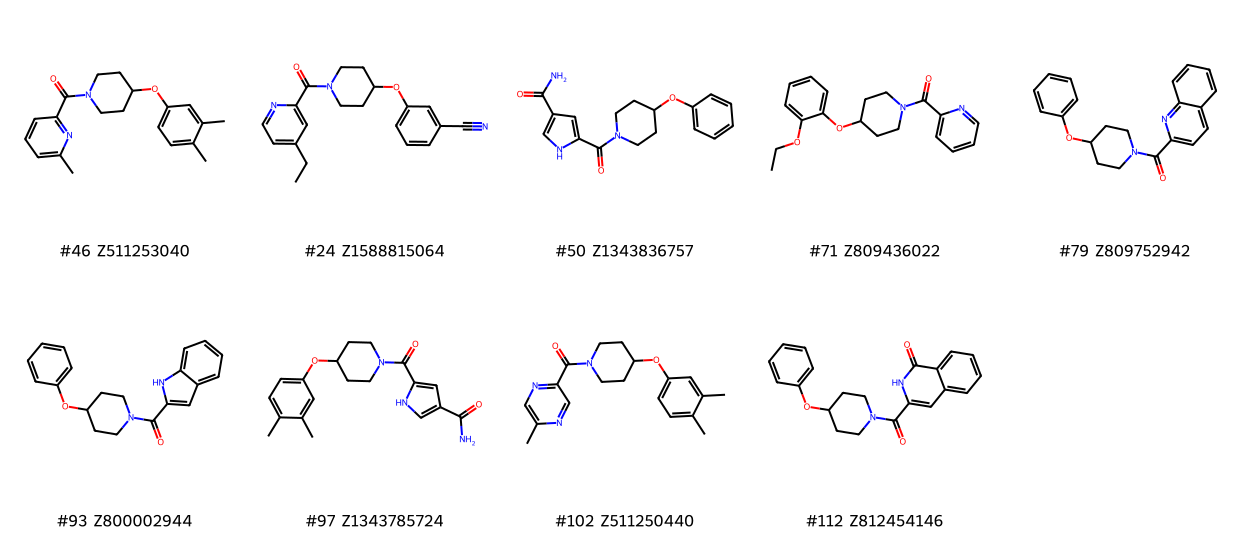

In [ ]:
print(f'{len(molecules_cluster0)} moleculas del clúster de mayor tamaño')
legends = [
    f"#{index} {molecule['CatalogID']}"
    for index, molecule in molecules_cluster0.iterrows()
]

Chem.Draw.MolsToGridImage(
    mols= molecules_cluster0["ROMol"].tolist(),
    legends=legends,
    molsPerRow=5,
    subImgSize=(250, 270),
)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


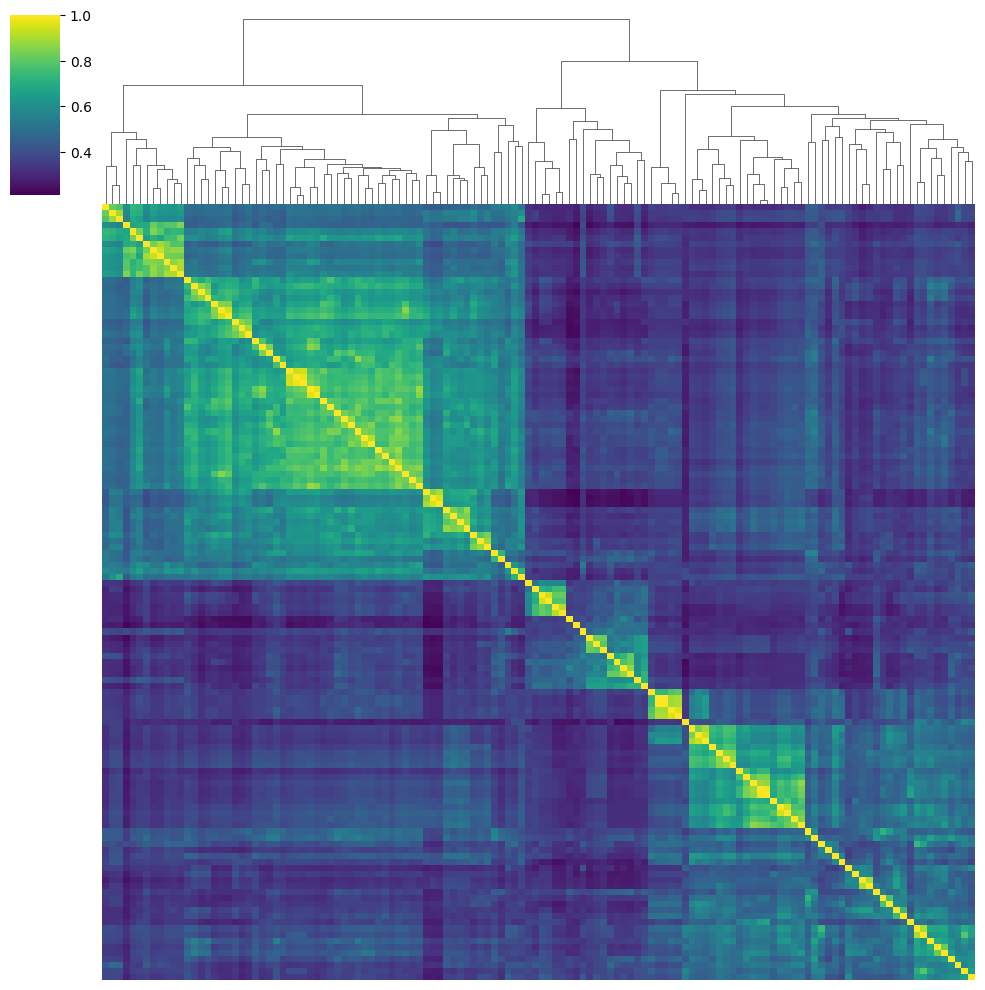

In [ ]:
from matplotlib.pyplot import figure

# Calcula la matriz de similitud con las huellas RDK5
similarity_matrix_full = tanimoto_matrix(rdk5_fp_list)

# Configura la figura con una mayor resolución y ajusta la paleta de colores
g = sns.clustermap(similarity_matrix_full, cmap="viridis",
                   dendrogram_ratio=(0.1, 0.2),
                   yticklabels=False, xticklabels=False,
                   figsize=(10, 10))

# Elimina el dendrograma de filas
g.ax_row_dendrogram.remove()
!mkdir -p data/
# Guarda la figura en alta resolución
plt.savefig('./data/TanimotoSimilarity.png', bbox_inches='tight')

# Muestra la figura
plt.show()
plt.close()


descarga de clusters

In [ ]:
import pandas as pd

# Crea una nueva columna 'Cluster' en el DataFrame original
molecule_dataset['Cluster'] = -1  # Inicializa con un valor predeterminado

# Itera a través de los clústeres y etiqueta los datos
for cluster_id, cluster in enumerate(clusters):
    list_ind_cluster = list(cluster)
    molecule_dataset.loc[list_ind_cluster, 'Cluster'] = cluster_id

# Reorganiza el DataFrame para agrupar los compuestos por clúster
sorted_molecule_dataset = molecule_dataset.sort_values('Cluster')

# Guarda el DataFrame reorganizado en un solo archivo CSV
sorted_molecule_dataset.to_csv('molecule_clusters.csv', index=False)

In [ ]:
import pandas as pd

# Carga tus datos desde el archivo CSV
data = pd.read_csv('molecule_clusters.csv')

# Ordena los datos por QED de manera descendente
sorted_data = data.sort_values(by='QED', ascending=False)

# Elimina filas duplicadas basadas en la columna 'Cluster'
unique_data = sorted_data.drop_duplicates(subset='Cluster', keep='first')

# Selecciona las mejores 12 filas
top_12_data = unique_data.head(12)

# Guarda los datos seleccionados en un nuevo archivo CSV
top_12_data.to_csv('mejores_datos.csv', columns=['CatalogID', 'SMILES', 'QED', 'Probabilidad_Multitarget'], index=False)
print(top_12_data[['CatalogID', 'SMILES', 'QED', 'Probabilidad_Multitarget']])

       CatalogID                                           SMILES       QED  \
86   Z2255297702                 CN1CCC(CCNC(=O)c2cc3ccncc3s2)CC1  0.944413   
96   Z2947117512          COc1cc(=O)[nH]cc1C(=O)N1CCCCCC1c1cccn1C  0.940517   
117  Z2782581648        Cc1cc(=O)[nH]cc1C(=O)N1CCC(Oc2ccccc2F)CC1  0.940444   
49   Z2242906264         Cc1cccc(Cn2cccc(C(=O)N3CCCC(N)C3)c2=O)c1  0.934938   
100  Z1389727601         Cn1cc(C(N)=O)cc1C(=O)N1CCCC1Cc1ccc(F)cc1  0.933286   
107  Z1816174900      CN(C(=O)NC1CCN(C(=O)c2ccccn2)C1)c1ccc(F)cc1  0.930608   
120  Z1675144399         CN(C)c1ccncc1C(=O)N1CCC(Nc2ccc(F)cc2)CC1  0.927903   
93   Z1894819123         COc1cccc(C2(NC(=O)c3c(C)ccn3C)CCOCC2)c1F  0.926086   
55   Z1426652980     COc1cccc2cc(C(=O)NC3CCN(C(=O)C4CCCC4)C3)oc12  0.914160   
103  Z1729456345  COc1cc(C)c(NC(=O)[C@@H]2CCCN2C(=O)c2ccccn2)cc1F  0.913340   
28   Z1343836757       NC(=O)c1c[nH]c(C(=O)N2CCC(Oc3ccccc3)CC2)c1  0.901762   
102  Z1254387889      CN(C)C(=O)c1cc(NC(=O)NC2(c3ccc

# Referencias

1.  Seo, M., Shin, H. K., Myung, Y., Hwang, S., & No, K. T. (2020). Development of natural compound molecular fingerprint (Nc-mfp) with the dictionary of natural products (Dnp) for natural product-based drug development. Journal of Cheminformatics, 12(1), 6. https://doi.org/10.1186/s13321-020-0410-3
2. Capecchi, A., Probst, D., & Reymond, J.-L. (2020). One molecular fingerprint to rule them all: Drugs, biomolecules, and the metabolome. Journal of Cheminformatics, 12(1), 43. https://doi.org/10.1186/s13321-020-00445-4
3. Rácz, A., Bajusz, D., & Héberger, K. (2018). Life beyond the Tanimoto coefficient: Similarity measures for interaction fingerprints. Journal of Cheminformatics, 10(1), 48. https://doi.org/10.1186/s13321-018-0302-y
4. Nielsen, F. (2016). Hierarchical clustering. En F. Nielsen (Ed.), Introduction to HPC with MPI for Data Science (pp. 195-211). Springer International Publishing. https://doi.org/10.1007/978-3-319-21903-5_8
5. Butina, D. (1999). Unsupervised data base clustering based on daylight’s fingerprint and tanimoto similarity: A fast and automated way to cluster small and large data sets. Journal of Chemical Information and Computer Sciences, 39(4), 747-750. https://doi.org/10.1021/ci9803381
6. Shi, C., Wei, B., Wei, S., Wang, W., Liu, H., & Liu, J. (2021). A quantitative discriminant method of elbow point for the optimal number of clusters in clustering algorithm. EURASIP Journal on Wireless Communications and Networking, 2021(1), 31. https://doi.org/10.1186/s13638-021-01910-w